In [ ]:
import laspy as lp
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.neighbors import KDTree
from sklearn.mixture import GaussianMixture

def read_las_file(las_path):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return (rgba * 255).astype(np.uint8)

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  

def get_points_and_colors(las_paths: list, limit: int = -1):
    if not isinstance(las_paths, list) or not all(isinstance(path, str) for path in las_paths):
        raise ValueError("las_paths must be a list of strings.")

    if not isinstance(limit, int) or limit < -1:
        raise ValueError("limit must be an integer greater than or equal to -1.")

    points = []
    colors = []
    classes = []

    for las_path in las_paths:
        las = read_las_file(las_path)
        if las is not None:
            points.append(np.vstack((las.x, las.y, las.z)).transpose())
            colors.append(np.vstack((las.red, las.green, las.blue)).transpose())
            classes.append(las.classification)

    if not points:
        raise ValueError("No valid LAS files found.")

    points = np.vstack(points)
    colors = np.vstack(colors)
    classes = np.hstack(classes)

    if limit > 0:
        idxs = np.random.choice(len(points), limit, replace=False)
        points = points[idxs]
        colors = colors[idxs]
        classes = classes[idxs]

    rgba_colors = normalize_colors(colors)

    return points, colors, rgba_colors, classes 


def get_neighborhood(kdtree, point_idx, radius):
    indices = kdtree.query_radius([kdtree.data[point_idx]], r=radius)
    return indices[0]

def automatic_gmm_components(data, max_components=2, criterion='aic', T=0.3, **kwargs):
    n_components_range = range(1, max_components + 1)
    criterions, means = [], []
    if criterion not in ['aic', 'bic']:
        raise ValueError("Criterio no válido. Usa 'bic' o 'aic'.")
    
    for n in n_components_range:
        try:
            gmm = GaussianMixture(n_components=n, **kwargs)
            gmm.fit(data)
            criterions.append(gmm.bic(data)) if criterion == 'bic' else criterions.append(gmm.aic(data))
            means.append(gmm.means_)
            
        except ValueError as e:
            print(f"Error fitting GMM with {n} components: {e}")
            break

    optimal_idx = np.argmin(criterions)
    optimal_means = means[optimal_idx]
    optimal_components = n_components_range[optimal_idx]
    
    if optimal_components == 2 and abs(optimal_means[0] - optimal_means[1]) <= T:
       return 1, [np.mean(optimal_means, dtype=np.float32)]
    
    if not criterions:
        return 1, [np.mean(data, dtype=np.float32)]  # Si no se pudo ajustar ningún modelo, devolver 1 componente
    
    return optimal_components, means[optimal_idx]

In [34]:
import os
import tempfile
from joblib import Parallel, delayed

def process_chunk(chunk_indices, mmap_filename, shape, dtype, neighborhood_size_r):
    points = np.memmap(mmap_filename, dtype=dtype, mode='r', shape=shape)
    kdtree = KDTree(points[:,:2])
    chunk_results = []
    
    for i in chunk_indices:
        indices = get_neighborhood(kdtree, i, neighborhood_size_r)
        z_neighborhood = points[indices, 2]
        
        if len(z_neighborhood) < 2:
            continue
            
        z_neighborhood = z_neighborhood.reshape(-1, 1)
        optimal_n_components, _ = automatic_gmm_components(z_neighborhood)
        
        chunk_results.append([
            points[i, 0], 
            points[i, 1], 
            points[i, 2], 
            optimal_n_components,
        ])
    
    return chunk_results

def main(points, neighborhood_size=1):
    
    # Configurar archivo temporal para memoria compartida
    temp_dir = tempfile.mkdtemp()
    mmap_filename = os.path.join(temp_dir, 'points.dat')
    fp = np.memmap(mmap_filename, dtype=points.dtype, mode='w+', shape=points.shape)
    fp[:] = points[:]
    del fp  # Liberar recursos y asegurar escritura
    
    # Configurar paralelización
    n_jobs = os.cpu_count()  # Usar todos los núcleos disponibles
    indices = np.arange(len(points))
    chunks = np.array_split(indices, n_jobs * 4)  # Dividir en más chunks para balanceo de carga
    
    # Procesar en paralelo
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_chunk)(
            chunk,
            mmap_filename,
            points.shape,
            points.dtype,
            neighborhood_size
        ) for chunk in tqdm(chunks, desc="Processing Chunks", position=0, leave=True) #chunks
    )
    
    # Limpiar y combinar resultados
    final_result = [item for sublist in results for item in sublist]
    
    # Limpiar archivos temporales
    try:
        os.remove(mmap_filename)
        os.rmdir(temp_dir)
    except Exception as e:
        print(f"Error limpiando archivos temporales: {e}")
    
    points_norm = np.array(final_result)
    points_, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(points_norm[:,:3])
    points_norm[:, :3] = points_
    
    return {
        'points': np.array(final_result),
        'points_norm': points_norm,
        'x_min': x_min,
        'x_max': x_max,
        'y_min': y_min,
        'y_max': y_max,
        'z_min': z_min,
        'z_max': z_max
    }

# Uso 
if __name__ == "__main__":
    NAME_PROJECT = 'RBS'
    PATH_PROJECT_LAS = f'../data/pozas_110125_100_10_120/{NAME_PROJECT}_col_0_row_1_19s.las' 
    LIMIT = 100_000

    points, colors, rgba_colors, classes = get_points_and_colors([PATH_PROJECT_LAS], limit=LIMIT)

    data = main(points, neighborhood_size=0.4) 
    points_norm = data.get('points_norm', None)

    one_result = points_norm[np.where(points_norm[:,3] == 1)][:,:-1]
    two_result = points_norm[np.where(points_norm[:,3] == 2)][:,:-1]

Processing Chunks:   0%|          | 0/64 [00:00<?, ?it/s][Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
/home/yeriel/workspace/sqm_batimetria/env/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/yeriel/workspace/sqm_batimetria/env/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/yeriel/workspace/sqm_batimetria/env/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/yeriel/workspace/sqm_batimetria/env/lib/python3.10/site-pac

In [35]:
import pyvista as pv

plotter = pv.Plotter()

one_result_polydata = pv.PolyData(one_result)
two_result_polydata = pv.PolyData(two_result)

plotter.add_points(one_result_polydata, color='blue', point_size=5)
plotter.add_points(two_result_polydata, color='red', point_size=5)

# Mostrar el plotter
plotter.show()


Widget(value='<iframe src="http://localhost:33977/index.html?ui=P_0x7c91788c4eb0_12&reconnect=auto" class="pyv…

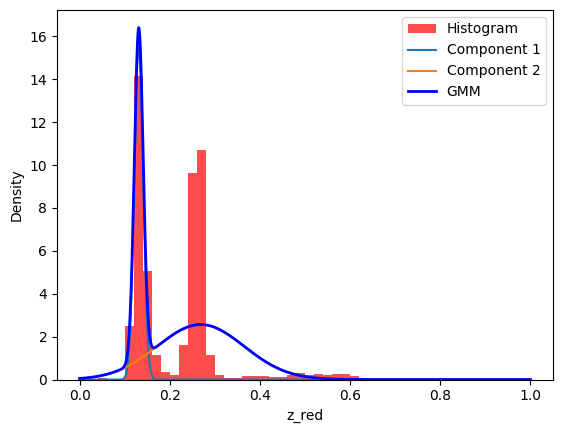

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

z_red = two_result[:, 2]

# Ajustar el modelo GMM
gmm = GaussianMixture(n_components=2)
gmm.fit(z_red.reshape(-1, 1))

# Extraer los parámetros de cada componente
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_.flatten()

# Generar los valores de la curva ajustada
x = np.linspace(z_red.min(), z_red.max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

# Graficar el histograma y la curva ajustada
plt.hist(z_red, bins=50, color='red', alpha=0.7, density=True, label='Histogram')

# Graficar cada componente gaussiano
for i in range(gmm.n_components):
    component_pdf = weights[i] * norm.pdf(x, means[i], stds[i])
    plt.plot(x, component_pdf, label=f'Component {i+1}')

# Graficar la curva total de la GMM
plt.plot(x, pdf, color='blue', lw=2, label='GMM')

plt.xlabel('z_red')
plt.ylabel('Density')
plt.legend()
plt.show()

In [37]:
import pyvista as pv

delta = 0.05
water_threshold = np.max(gmm.means_)

print(water_threshold)
water_points = two_result[(z_red < water_threshold + delta) & (z_red >= water_threshold -delta)]
below_water = two_result[z_red < water_threshold - delta]
above_water  = two_result[z_red > water_threshold + delta]


plotter = pv.Plotter()

# Añadir los puntos por debajo del agua en rojo
points_below = pv.PolyData(below_water)
plotter.add_points(points_below, color='green', point_size=5)

# Añadir los puntos por encima del sobre en azul
points_above = pv.PolyData(above_water)
plotter.add_points(points_above, color='red', point_size=5)

# Mostrar el plotter
plotter.show()


0.2685438785157503


Widget(value='<iframe src="http://localhost:33977/index.html?ui=P_0x7c917afffd60_13&reconnect=auto" class="pyv…

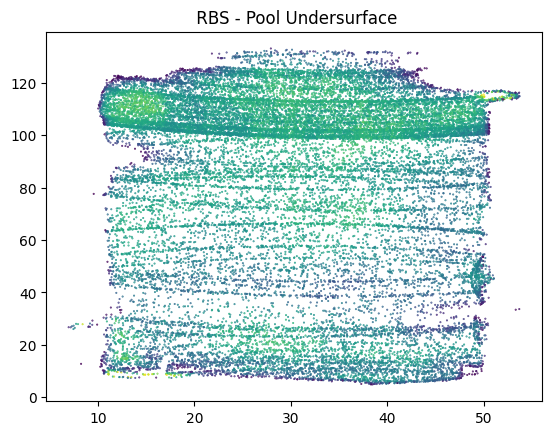

In [38]:
from sklearn.mixture import GaussianMixture

def get_outliers(z):
    gm = GaussianMixture(n_components=1, random_state=0).fit(z.reshape(-1, 1))
    mean = gm.means_[0, 0]
    std_dev = np.sqrt(gm.covariances_[0, 0, 0])
    threshold = 3 * std_dev
    outliers = np.abs(z - mean) > threshold
    return outliers

outliers = get_outliers(below_water)

x = below_water[:,0]
y = below_water[:,1]
z = below_water[:,2]

x = x[~get_outliers(z)]
y = y[~get_outliers(z)]
z = z[~get_outliers(z)]

x = x * (data.get('x_max') - data.get('x_min'))
y = y * (data.get('y_max') - data.get('y_min'))
z = z * (data.get('z_max') - data.get('z_min')) 

plt.title(f' {NAME_PROJECT} - Pool Undersurface')
plt.scatter(x, y, c=z, cmap='viridis_r', s=0.2)
#plt.colorbar()
plt.savefig(f'{NAME_PROJECT}_map_distance.png', dpi=300)
plt.show()


In [39]:
import numpy as np
import pyvista as pv
import pyransac3d as pyrsc

# Supongamos que `two_result` es tu matriz de datos
# Extraer las coordenadas x, y, z
X = two_result[:, 0]
Y = two_result[:, 1]
Z = two_result[:, 2]

 # Load your point cloud as a numpy array (N, 3)
plane1 = pyrsc.Plane()
best_eq, best_inliers = plane1.fit(water_points, 0.01)


# Si deseas obtener la ecuación del plano en forma Ax + By + Cz + D = 0
A, B, C, D  = best_eq 
print(f"Ecuación del plano: {A}x + {B}y + {C}z + {D} = 0")

# Calcular la distancia de cada punto al plano
distances = (A * X + B * Y + C * Z + D) / np.sqrt(A**2 + B**2 + C**2)

# Crear una malla de puntos para el plano
xx, yy = np.meshgrid(np.linspace(X.min(), X.max(), 10), np.linspace(Y.min(), Y.max(), 10))
zz = (-A * xx - B * yy - D) / C

# Crear una superficie para el plano
plane = pv.StructuredGrid(xx, yy, zz)

# Crear un plotter de PyVista
plotter = pv.Plotter()

# Separar los puntos por encima y por debajo del plano
below_plane = distances < -delta
above_plane = distances >= delta

# Añadir los puntos por debajo del plano en rojo
points_below = pv.PolyData(np.column_stack((X[below_plane], Y[below_plane], Z[below_plane])))
plotter.add_points(points_below, color='red', point_size=5)

# Añadir los puntos por encima del plano en azul
points_above = pv.PolyData(np.column_stack((X[above_plane], Y[above_plane], Z[above_plane])))
plotter.add_points(points_above, color='blue', point_size=5)

# Añadir la superficie del plano al plotter
plotter.add_mesh(plane, color='green', opacity=0.5)

# Mostrar el plotter
plotter.show()

Ecuación del plano: -0.011969018115497462x + -0.011531942366158447y + -0.999861868915209z + 0.27147879174023326 = 0


Widget(value='<iframe src="http://localhost:33977/index.html?ui=P_0x7c917a0ea1a0_14&reconnect=auto" class="pyv…

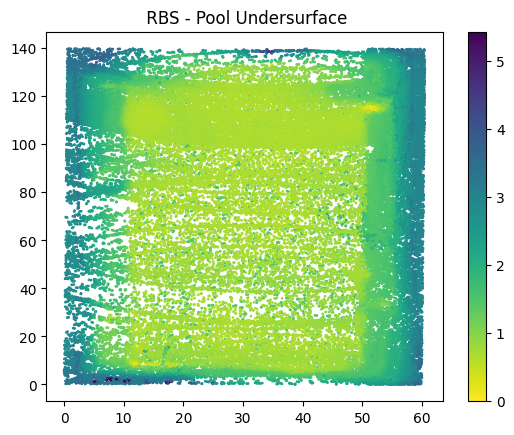

In [50]:
above_below = np.ma.mask_or(above_plane, below_plane, shrink=False)  

pool_points = two_result[above_below]
all_points = np.concatenate((one_result, pool_points), axis=0)

x = all_points[:, 0]
y = all_points[:,1]
z = all_points[:,2]

#x = points[below_plane,0]
#y = points[below_plane,1] 
#z = (-D) - points[below_plane,2]


x = x * (data.get('x_max') - data.get('x_min'))
y = y * (data.get('y_max') - data.get('y_min'))
z = z * (data.get('z_max') - data.get('z_min')) 



plt.title(f' {NAME_PROJECT} - Pool Undersurface')
plt.scatter(x, y, c=z, cmap='viridis_r', s=1)
plt.colorbar()
plt.savefig(f'{NAME_PROJECT}_map_distance.png', dpi=300)
plt.show()
